### Info:
- c1 is the gate voltage, c2- output voltage and c3- current.

### Todo:
- [x] Solve f such that f(c1, c3) = c2
- [ ] Solve f such that f(c1, c2) = c3
- [ ] Solve f such that f(c1) = c2, c3  (multiple ouputs)
- [ ] Differentiate between expt, ideal, model
- [ ] Differentiate between panasonic, transform, GaNsystems (use scalar parameters)
- [ ] Test meta-learning? - train on data from 2 devices, test on third?
    - Can also perform one-shot learning with ideal/model data to finally predict the expt data

In [1]:
import os
import glob
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dropout
from keras import backend as K

np.set_printoptions(suppress=True)

/home/saurabh/anaconda2/envs/pandagrader/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## Reading all data

In [3]:
base_dir = '../Nikki/data'
data_dirs = [f'{base_dir}/data_02_03_18', f'{base_dir}/data_01_12_18']

def read_data(data_dir):
    def is_it_c1_c2_or_c3(filename):
        return filename.split(' ')[-1].split('.')[0]
    
    dir_structures = list(os.walk(f'{data_dir}'))
    data_dicts = []
    for dirpath, dirnames, filenames in dir_structures[1:]:
        data_dict = {}
        data_dict['dir'] = dirpath
        for filename in filenames:
            data = is_it_c1_c2_or_c3(filename)
            data_dict[f'{data}_file'] = f'{filename}'
        device_name, data_type = dirpath.split('/')[-1].strip().split()
        data_dict['device_name'] = device_name.lower()
        data_dict['graph_type'] = data_type.lower()
        data_dict['date'] = '-'.join(data_dir.split('_')[-3:])
        data_dicts.append(data_dict)
    return data_dicts

df = pd.DataFrame(read_data(data_dirs[0]) + read_data(data_dirs[1]))

In [4]:
def read_datafile(filename):
    time, cx = zip(*[
        list(map(float, line.strip().split('\t'))) 
        for line in open(filename, 'r')
    ])
    return [t * 1e09 for t in time], list(cx)

df['c1'] = [read_datafile(f'{row.dir}/{row.c1_file}')[1] for _, row in df.iterrows()]
df['c2'] = [read_datafile(f'{row.dir}/{row.c2_file}')[1] for _, row in df.iterrows()]
df['c3'] = [read_datafile(f'{row.dir}/{row.c3_file}')[1] for _, row in df.iterrows()]
df['len'] = [len(row.c1) for _, row in df.iterrows()]
del df['dir']
df

,c1_file,c2_file,c3_file,date,device_name,graph_type,c1,c2,c3,len
0,panasonic ideal gate voltage c1.txt,panasonic ideal switching voltage c2.txt,panasonic ideal current c3.txt,02-03-18,panasonic,ideal,"[4.12497, 4.12497, 4.12497, 4.12497, 4.12497, ...","[4.12497, 4.12497, 4.12497, 4.12497, 4.12497, ...","[20.5625, 20.5625, 20.5625, 20.5625, 20.5625, ...",1002
1,transphorm ideal gate voltage c1.txt,transphorm ideal voltage c2.txt,Transphorm ideal current c3.txt,02-03-18,transphorm,ideal,"[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, ...","[3.12497, 3.12497, 3.12497, 3.12497, -3.05e-05...","[20.5625, 20.5625, 20.875, 20.875, 21.1875, 20...",1002
2,GaNsystems ideal gate voltage c1.txt,GaNSystems ideal switching voltage c2.txt,GaNsystems ideal current c3.txt,02-03-18,gansystems,ideal,"[6.00123, 6.00123, 6.00123, 6.00123, 6.00123, ...","[3.12497, 3.12497, 3.12497, 3.12497, 3.12497, ...","[15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15....",1002
3,panasonic gate voltage c1.txt,panasonic model voltage c2.txt,panasonic model current c3.txt,02-03-18,panasonic,model,"[3.4375, 3.28125, 3.4375, 3.28125, 3.4375, 3.4...","[4.12497, 3.59375, 3.59375, 3.4375, 3.4375, 3....","[20.25, 20.5625, 20.5625, 20.5625, 20.875, 20....",1002
4,transphorm expt gate voltage c1.txt,transphorm expt voltage c2.txt,Transphorm expt current c3.txt,02-03-18,transphorm,expt,"[7.4375, 7.125, 7.59375, 7.4375, 7.28125, 7.28...","[7.5, 4.375, 7.5, 4.375, 4.375, 4.375, 10.625,...","[20.5625, 20.5625, 20.875, 20.875, 21.1875, 20...",1002
5,GaNsystems model gate voltage c1.txt,GaNSystems model switching voltage c2.txt,GaNsystems model current c3.txt,02-03-18,gansystems,model,"[5.90123, 5.90123, 5.90123, 5.90123, 5.90123, ...","[6.24997, 3.12497, -3.05e-05, -3.05e-05, 3.124...","[15.25, 15.25, 15.25, 15.25, 15.25, 15.25, 15....",1002
6,GaNsystems expt gate voltage c1.txt,GaNSystems expt switching voltage c2.txt,GaNsystems expt current c3.txt,02-03-18,gansystems,expt,"[6.41563, 6.25625, 5.9375, 6.25625, 6.25625, 6...","[6.24997, 3.12497, -3.05e-05, -3.05e-05, 3.124...","[15.25, 15.5625, 15.5625, 15.875, 15.5625, 15....",1002
7,transphorm model gate voltage c1.txt,transphorm model voltage c2.txt,Transphorm model current c3.txt,02-03-18,transphorm,model,"[8.4375, 8.125, 8.59375, 8.4375, 8.28125, 8.28...","[3.12497, 3.12497, 3.12497, 3.12497, -3.05e-05...","[20.25, 20.875, 20.5625, 20.875, 20.25, 20.875...",1002
8,panasonic expt gate voltage c1.txt,panasonic expt voltage c2.txt,panasonic expt current c3.txt,02-03-18,panasonic,expt,"[3.4375, 3.125, 3.59375, 3.4375, 3.28125, 3.28...","[4.375, 1.25, 1.25, 7.5, 1.25, 1.25, -1.875, 4...","[20.5625, 20.5625, 20.875, 20.875, 21.1875, 20...",1002
9,panasonic ideal gate voltage c1.txt,panasonic ideal switching voltage c2.txt,panasonic ideal current c3.txt,01-12-18,panasonic,ideal,"[3.1375, 3.1375, 3.1375, 3.1375, 3.1375, 3.137...","[4.12497, 4.12497, 4.12497, 4.12497, 4.12497, ...","[20.5625, 20.5625, 20.5625, 20.5625, 20.5625, ...",1002


## Ploting all data

In [5]:
def plot_data(c1, c2, c3, c1_pred=None, c2_pred=None, c3_pred=None, title=None):
    assert len(c1) == len(c2) == len(c3)
    plts = {}
    fig, ax1 = plt.subplots(1,1, figsize=(16, 8))
    if title:
        ax1.set_title(title)
    x = range(len(c1))

    plts['c2'] = ax1.plot(x, c2, c='b', label='c2/output voltage')
    if c2_pred is not None:
        plts['c2_pred'] = ax1.plot(x, c2_pred, c='k', label='c2 pred/output voltage')
    ax1.set_ylabel('Output voltage (Vds)', color='b')
    ax1.tick_params('y', colors='b')
    ax1.set_xlabel('time steps')

    ax2 = ax1.twinx()
    plts['c1'] = ax2.plot(x, c1, c='g', label='c1/gate voltage')
    plts['c3'] = ax2.plot(x, c3, c='r', label='c3/current')
    if c1_pred is not None:
        plts['c1_pred'] = ax2.plot(x, c1_pred, c='k', label='c1 pred/gate voltage')
    if c3_pred is not None:
        plts['c3_pred'] = ax2.plot(x, c3_pred, c='k', label='c3 pred/current')        
        
    ax2.set_ylabel('Gate voltage (Vgs) / Current (Ids)', color='r')
    ax2.tick_params('y', colors='r')

    plts_list = [plts[k][0] for k in sorted(list(plts.keys()))]
    labels = [l.get_label() for l in plts_list]
    ax1.legend(plts_list, labels, loc='upper right')

In [6]:
df.date.unique()

array(['02-03-18', '01-12-18'], dtype=object)

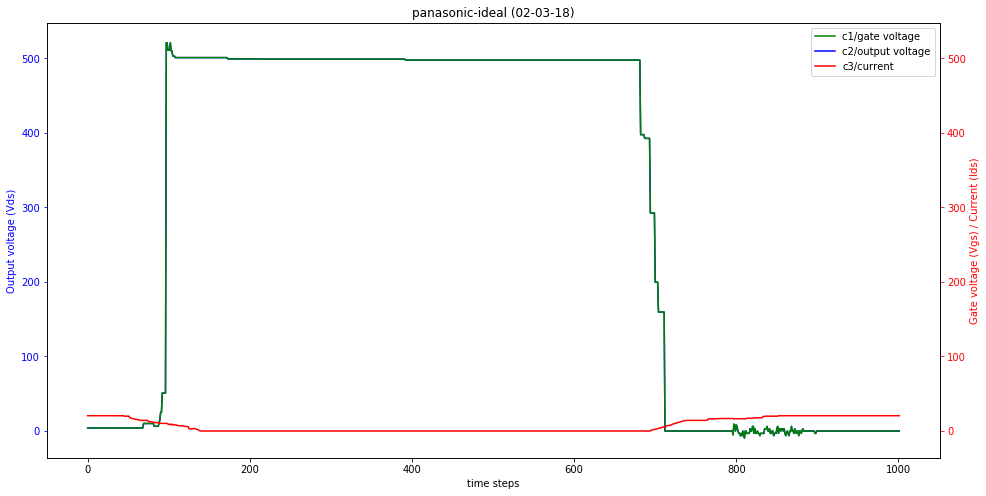

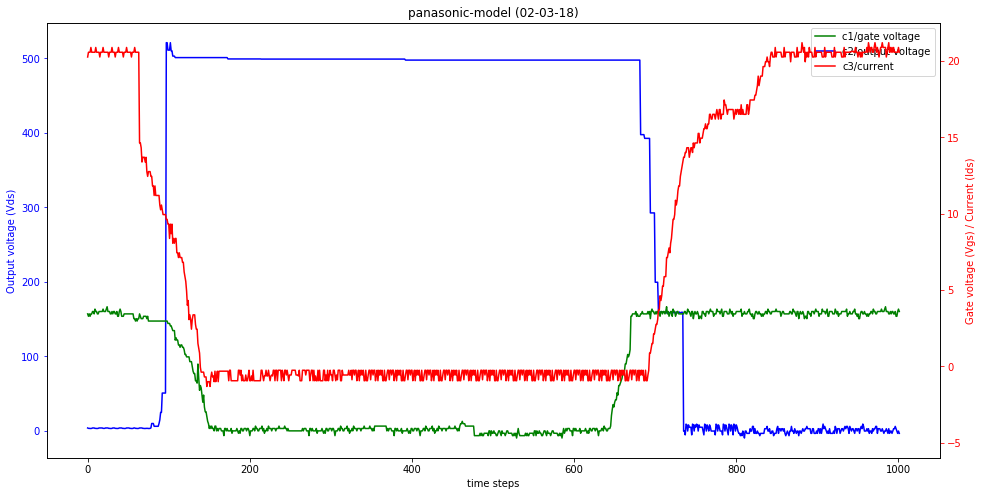

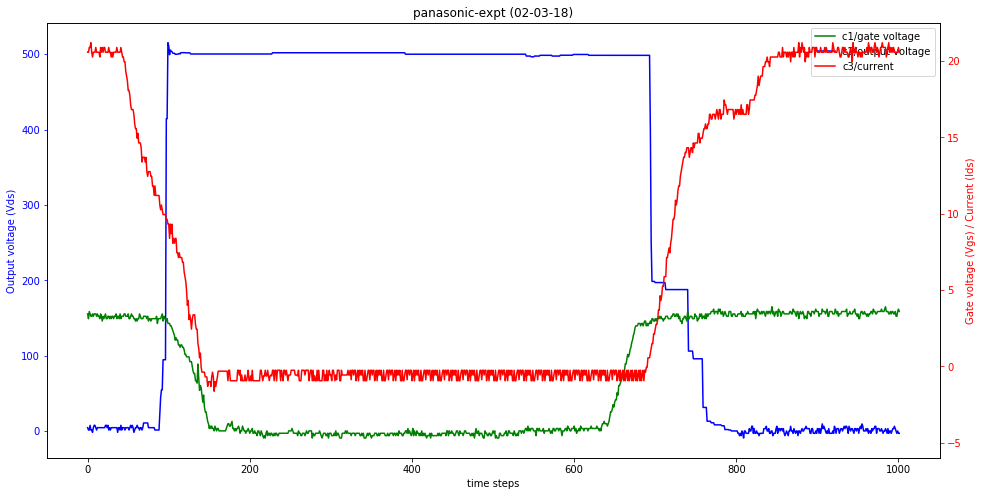

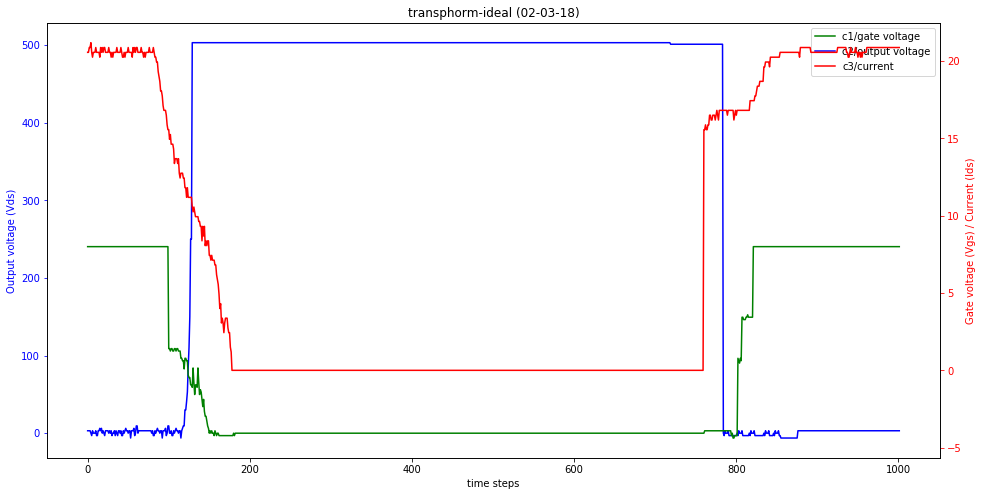

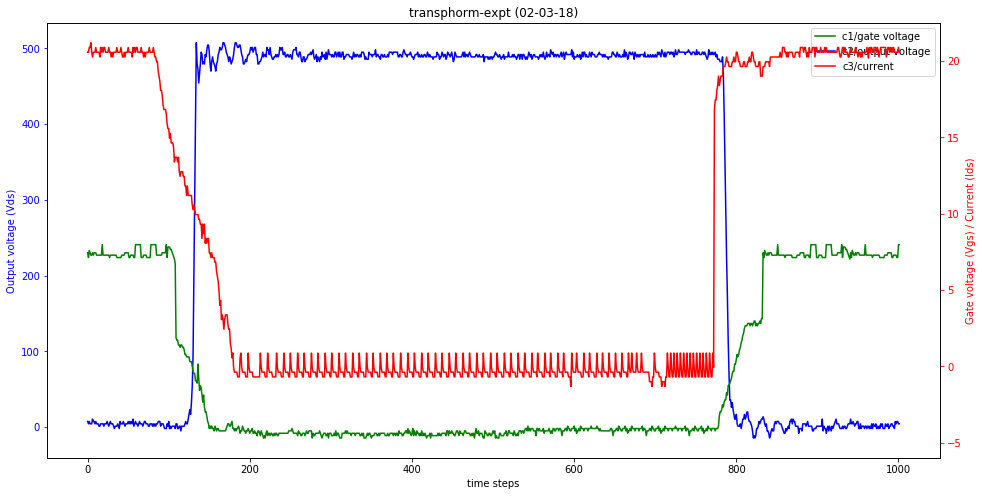

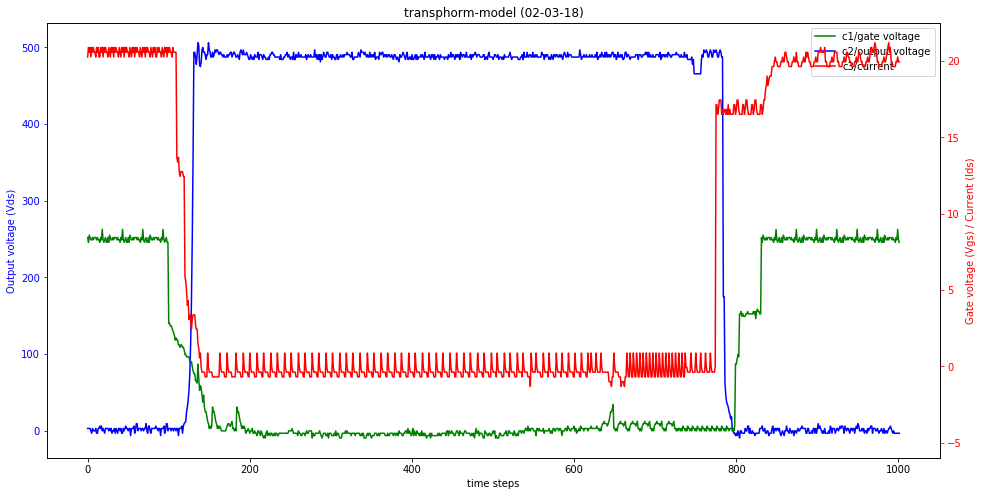

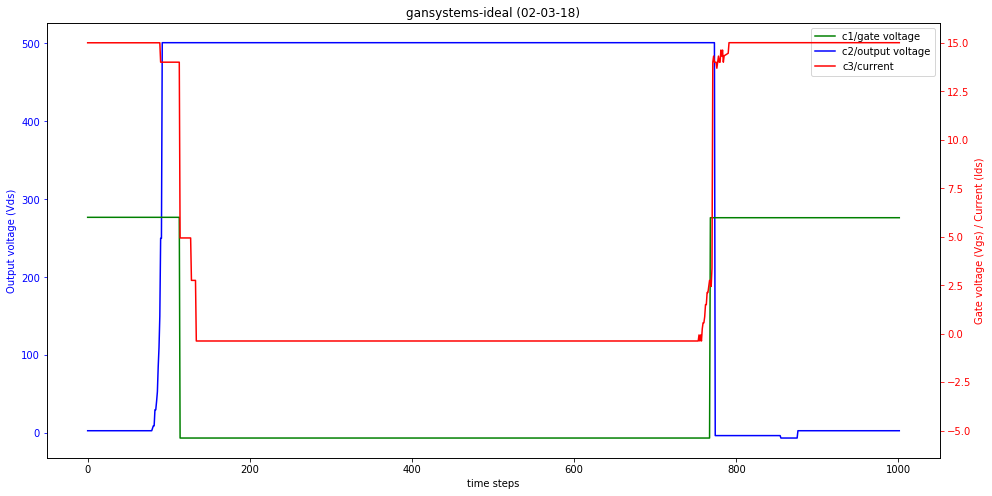

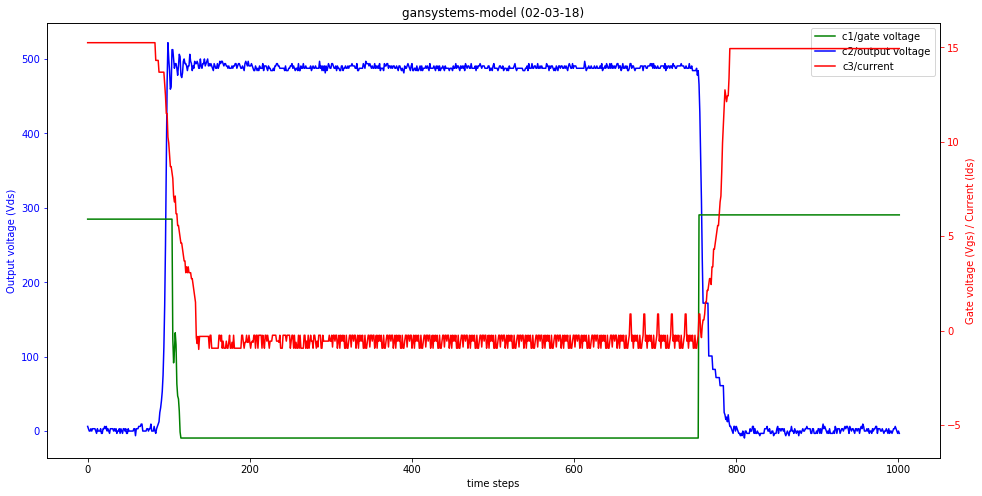

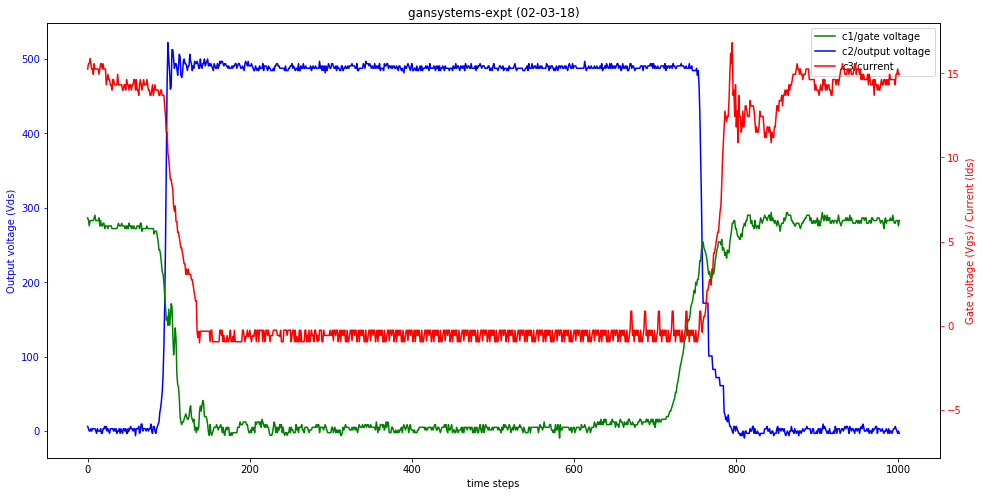

In [7]:
## So let's understand what's the difference between expt, model, ideal
def plot_all_graphs_on(date):
    for device_name in df.device_name.unique():
        plot_df = df[(df.device_name == device_name) & (df.date == date)]
        for _, row in plot_df.iterrows():
            plot_data(row.c1, row.c2, row.c3, title=f'{row.device_name}-{row.graph_type} ({row.date})')
            
plot_all_graphs_on('02-03-18')

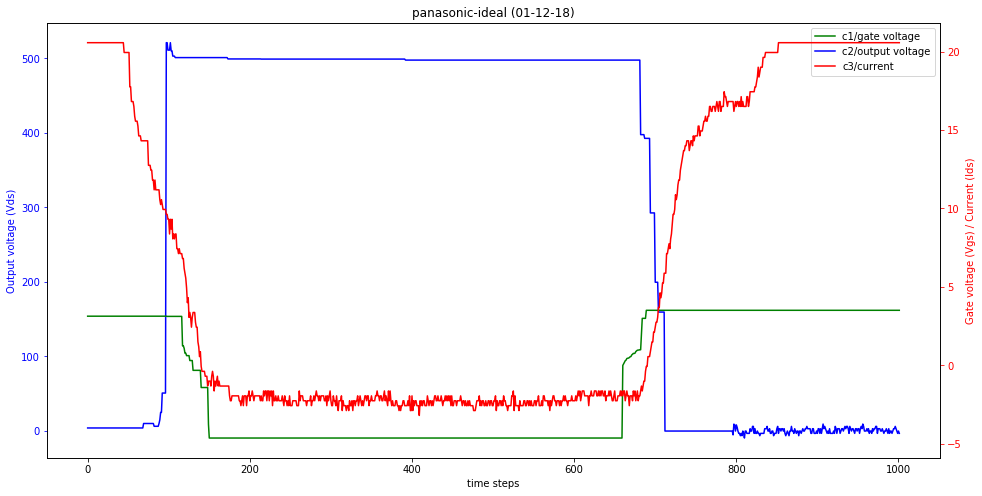

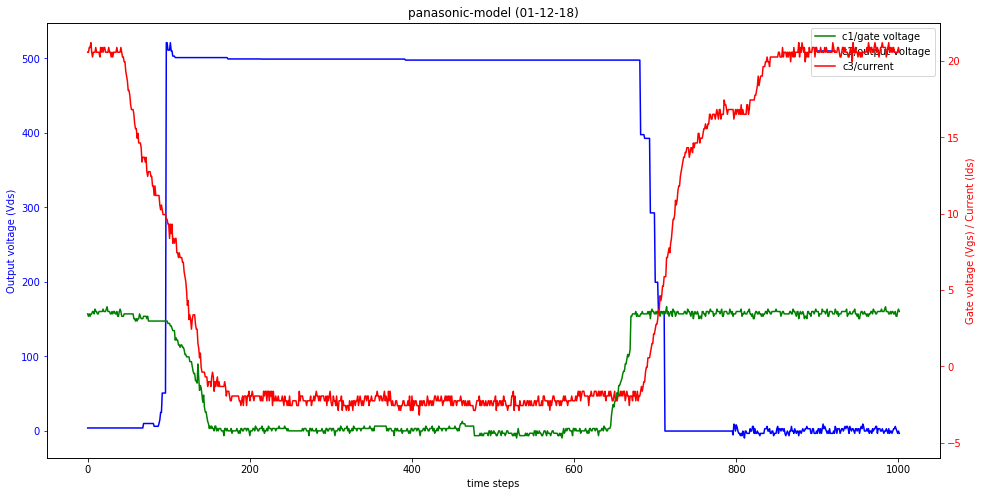

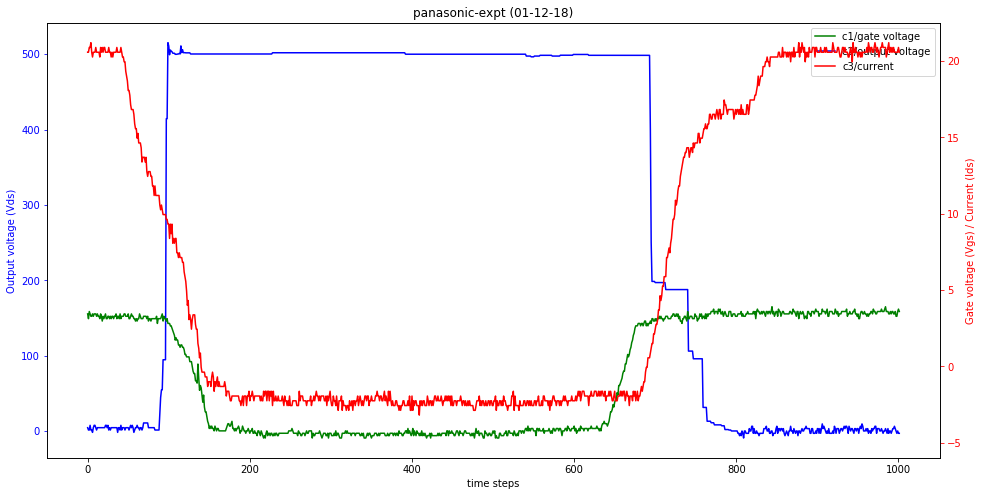

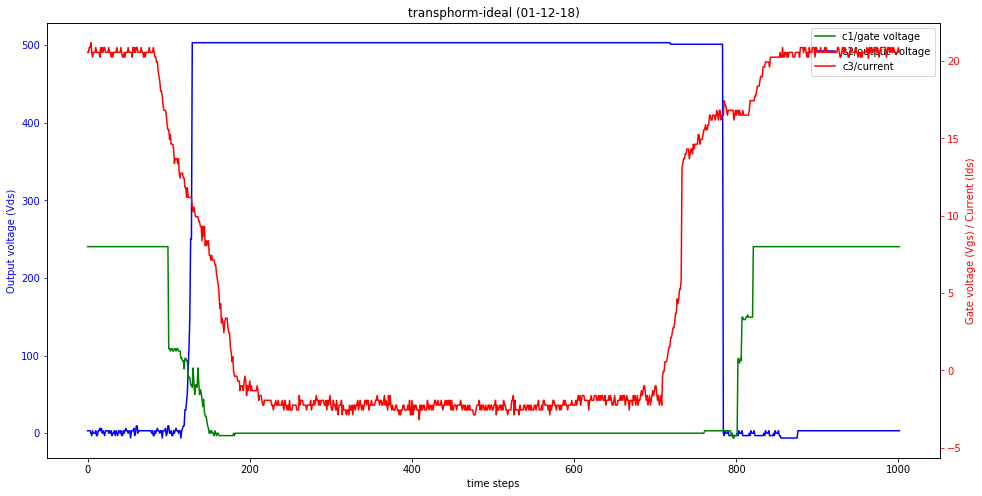

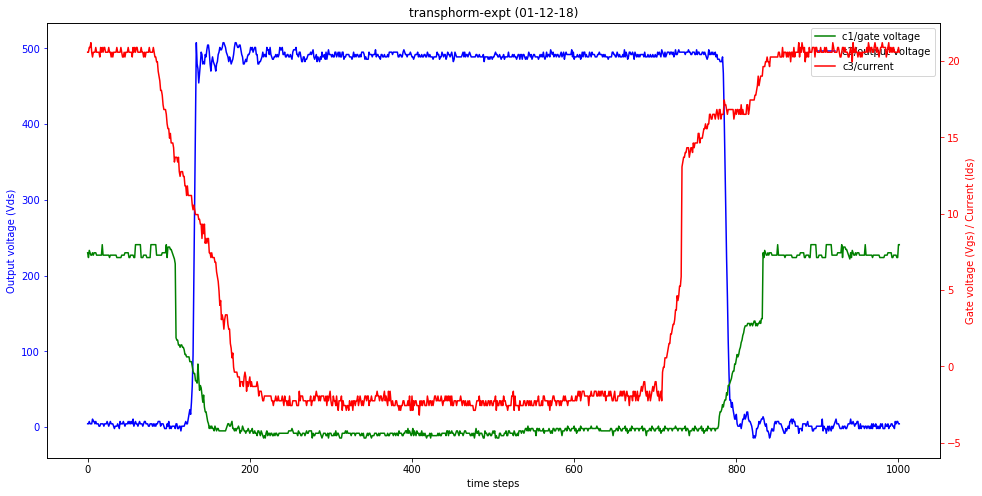

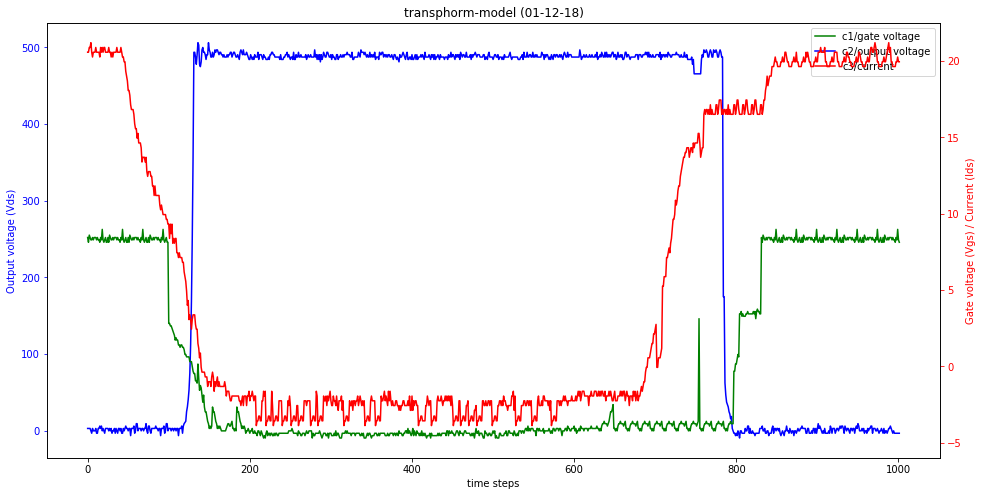

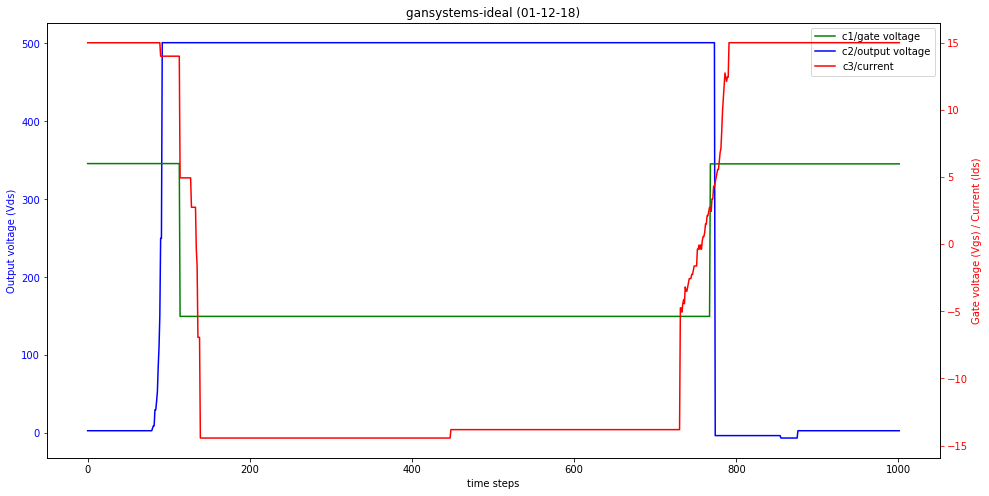

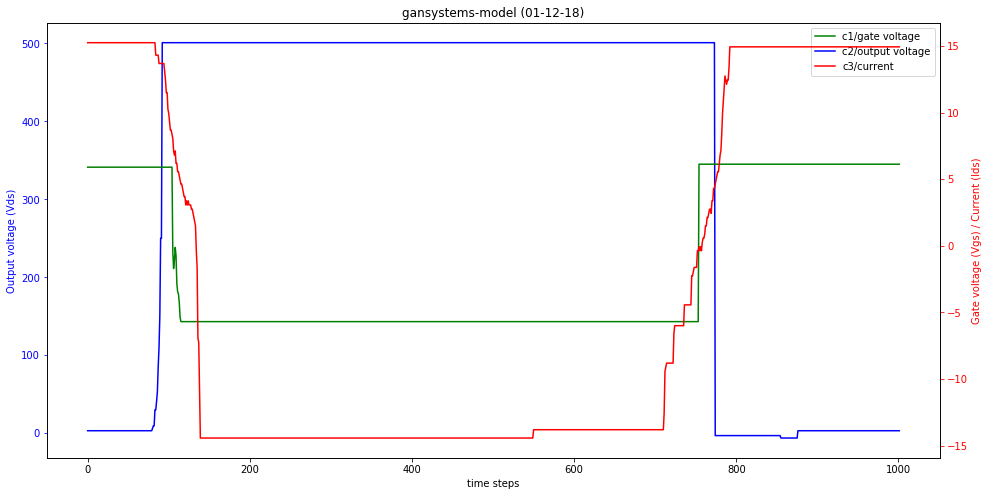

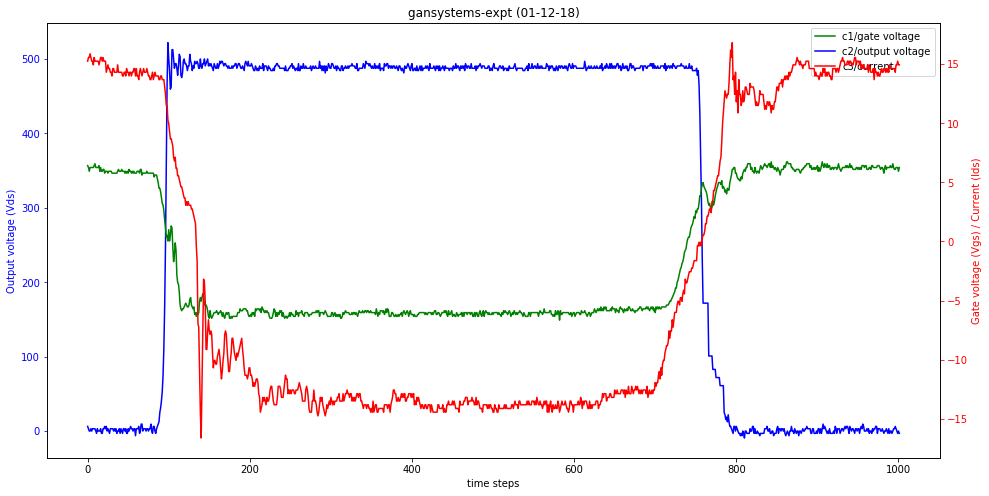

In [8]:
plot_all_graphs_on('01-12-18')

### From observation, there seems to be a problem with Panasonic-ideal (02-03-18) - so remove it

In [9]:
drop_index = df[(df.device_name == 'panasonic') & (df.date == '02-03-18') & (df.graph_type == 'ideal')].index
df.drop(df.index[drop_index], inplace=True)
df

,c1_file,c2_file,c3_file,date,device_name,graph_type,c1,c2,c3,len
1,transphorm ideal gate voltage c1.txt,transphorm ideal voltage c2.txt,Transphorm ideal current c3.txt,02-03-18,transphorm,ideal,"[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, ...","[3.12497, 3.12497, 3.12497, 3.12497, -3.05e-05...","[20.5625, 20.5625, 20.875, 20.875, 21.1875, 20...",1002
2,GaNsystems ideal gate voltage c1.txt,GaNSystems ideal switching voltage c2.txt,GaNsystems ideal current c3.txt,02-03-18,gansystems,ideal,"[6.00123, 6.00123, 6.00123, 6.00123, 6.00123, ...","[3.12497, 3.12497, 3.12497, 3.12497, 3.12497, ...","[15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15....",1002
3,panasonic gate voltage c1.txt,panasonic model voltage c2.txt,panasonic model current c3.txt,02-03-18,panasonic,model,"[3.4375, 3.28125, 3.4375, 3.28125, 3.4375, 3.4...","[4.12497, 3.59375, 3.59375, 3.4375, 3.4375, 3....","[20.25, 20.5625, 20.5625, 20.5625, 20.875, 20....",1002
4,transphorm expt gate voltage c1.txt,transphorm expt voltage c2.txt,Transphorm expt current c3.txt,02-03-18,transphorm,expt,"[7.4375, 7.125, 7.59375, 7.4375, 7.28125, 7.28...","[7.5, 4.375, 7.5, 4.375, 4.375, 4.375, 10.625,...","[20.5625, 20.5625, 20.875, 20.875, 21.1875, 20...",1002
5,GaNsystems model gate voltage c1.txt,GaNSystems model switching voltage c2.txt,GaNsystems model current c3.txt,02-03-18,gansystems,model,"[5.90123, 5.90123, 5.90123, 5.90123, 5.90123, ...","[6.24997, 3.12497, -3.05e-05, -3.05e-05, 3.124...","[15.25, 15.25, 15.25, 15.25, 15.25, 15.25, 15....",1002
6,GaNsystems expt gate voltage c1.txt,GaNSystems expt switching voltage c2.txt,GaNsystems expt current c3.txt,02-03-18,gansystems,expt,"[6.41563, 6.25625, 5.9375, 6.25625, 6.25625, 6...","[6.24997, 3.12497, -3.05e-05, -3.05e-05, 3.124...","[15.25, 15.5625, 15.5625, 15.875, 15.5625, 15....",1002
7,transphorm model gate voltage c1.txt,transphorm model voltage c2.txt,Transphorm model current c3.txt,02-03-18,transphorm,model,"[8.4375, 8.125, 8.59375, 8.4375, 8.28125, 8.28...","[3.12497, 3.12497, 3.12497, 3.12497, -3.05e-05...","[20.25, 20.875, 20.5625, 20.875, 20.25, 20.875...",1002
8,panasonic expt gate voltage c1.txt,panasonic expt voltage c2.txt,panasonic expt current c3.txt,02-03-18,panasonic,expt,"[3.4375, 3.125, 3.59375, 3.4375, 3.28125, 3.28...","[4.375, 1.25, 1.25, 7.5, 1.25, 1.25, -1.875, 4...","[20.5625, 20.5625, 20.875, 20.875, 21.1875, 20...",1002
9,panasonic ideal gate voltage c1.txt,panasonic ideal switching voltage c2.txt,panasonic ideal current c3.txt,01-12-18,panasonic,ideal,"[3.1375, 3.1375, 3.1375, 3.1375, 3.1375, 3.137...","[4.12497, 4.12497, 4.12497, 4.12497, 4.12497, ...","[20.5625, 20.5625, 20.5625, 20.5625, 20.5625, ...",1002
10,transphorm ideal gate voltage c1.txt,transphorm ideal voltage c2.txt,Transphorm ideal current c3.txt,01-12-18,transphorm,ideal,"[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, ...","[3.12497, 3.12497, 3.12497, 3.12497, -3.05e-05...","[20.5625, 20.5625, 20.875, 20.875, 21.1875, 20...",1002


## Splitting data for training

 - Data info: 17 plots in total (**6 `expts`**, 6 `model`, 5 `ideal`)
 - We should `test` the model **only** on `expt` data as that is the final objective.
 - 2 logical ways to generate the `test` data:
     - have 1 plot from each of the devices - implying the data for that device has been exposed to the model during training
     - have 2 plots from a specific device - implying the data for that device has **not** been exposed to the model during training (this is a case of meta-learning)
 - Due to the limited data (especially `expt`), we decide not to have a `validation` data split

In [28]:
## Taking Approach 1 for test data 
# - have 1 plot from each of the devices 
# - implying the data for that device has been exposed to the model during training

test_date = '02-03-18'
test_df = df[(df.graph_type == 'expt') & (df.date == test_date)]
test_df

,c1_file,c2_file,c3_file,date,device_name,graph_type,c1,c2,c3,len,c2_loss,c3_loss
4,transphorm expt gate voltage c1.txt,transphorm expt voltage c2.txt,Transphorm expt current c3.txt,02-03-18,transphorm,expt,"[7.4375, 7.125, 7.59375, 7.4375, 7.28125, 7.28...","[7.5, 4.375, 7.5, 4.375, 4.375, 4.375, 10.625,...","[20.5625, 20.5625, 20.875, 20.875, 21.1875, 20...",1002,0.0,0.0
6,GaNsystems expt gate voltage c1.txt,GaNSystems expt switching voltage c2.txt,GaNsystems expt current c3.txt,02-03-18,gansystems,expt,"[6.41563, 6.25625, 5.9375, 6.25625, 6.25625, 6...","[6.24997, 3.12497, -3.05e-05, -3.05e-05, 3.124...","[15.25, 15.5625, 15.5625, 15.875, 15.5625, 15....",1002,0.0,0.0
8,panasonic expt gate voltage c1.txt,panasonic expt voltage c2.txt,panasonic expt current c3.txt,02-03-18,panasonic,expt,"[3.4375, 3.125, 3.59375, 3.4375, 3.28125, 3.28...","[4.375, 1.25, 1.25, 7.5, 1.25, 1.25, -1.875, 4...","[20.5625, 20.5625, 20.875, 20.875, 21.1875, 20...",1002,0.0,0.0


In [29]:
train_df = df.copy()
train_df.drop(test_df.index, inplace=True)
train_df

,c1_file,c2_file,c3_file,date,device_name,graph_type,c1,c2,c3,len,c2_loss,c3_loss
1,transphorm ideal gate voltage c1.txt,transphorm ideal voltage c2.txt,Transphorm ideal current c3.txt,02-03-18,transphorm,ideal,"[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, ...","[3.12497, 3.12497, 3.12497, 3.12497, -3.05e-05...","[20.5625, 20.5625, 20.875, 20.875, 21.1875, 20...",1002,0.026688,0.037400
2,GaNsystems ideal gate voltage c1.txt,GaNSystems ideal switching voltage c2.txt,GaNsystems ideal current c3.txt,02-03-18,gansystems,ideal,"[6.00123, 6.00123, 6.00123, 6.00123, 6.00123, ...","[3.12497, 3.12497, 3.12497, 3.12497, 3.12497, ...","[15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15....",1002,0.059139,0.021785
3,panasonic gate voltage c1.txt,panasonic model voltage c2.txt,panasonic model current c3.txt,02-03-18,panasonic,model,"[3.4375, 3.28125, 3.4375, 3.28125, 3.4375, 3.4...","[4.12497, 3.59375, 3.59375, 3.4375, 3.4375, 3....","[20.25, 20.5625, 20.5625, 20.5625, 20.875, 20....",1002,0.011308,0.003563
5,GaNsystems model gate voltage c1.txt,GaNSystems model switching voltage c2.txt,GaNsystems model current c3.txt,02-03-18,gansystems,model,"[5.90123, 5.90123, 5.90123, 5.90123, 5.90123, ...","[6.24997, 3.12497, -3.05e-05, -3.05e-05, 3.124...","[15.25, 15.25, 15.25, 15.25, 15.25, 15.25, 15....",1002,0.000005,0.006547
7,transphorm model gate voltage c1.txt,transphorm model voltage c2.txt,Transphorm model current c3.txt,02-03-18,transphorm,model,"[8.4375, 8.125, 8.59375, 8.4375, 8.28125, 8.28...","[3.12497, 3.12497, 3.12497, 3.12497, -3.05e-05...","[20.25, 20.875, 20.5625, 20.875, 20.25, 20.875...",1002,0.012093,0.045219
9,panasonic ideal gate voltage c1.txt,panasonic ideal switching voltage c2.txt,panasonic ideal current c3.txt,01-12-18,panasonic,ideal,"[3.1375, 3.1375, 3.1375, 3.1375, 3.1375, 3.137...","[4.12497, 4.12497, 4.12497, 4.12497, 4.12497, ...","[20.5625, 20.5625, 20.5625, 20.5625, 20.5625, ...",1002,0.026218,0.000317
10,transphorm ideal gate voltage c1.txt,transphorm ideal voltage c2.txt,Transphorm ideal current c3.txt,01-12-18,transphorm,ideal,"[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, ...","[3.12497, 3.12497, 3.12497, 3.12497, -3.05e-05...","[20.5625, 20.5625, 20.875, 20.875, 21.1875, 20...",1002,0.026688,0.000064
11,GaNsystems ideal gate voltage c1.txt,GaNSystems ideal switching voltage c2.txt,GaNsystems ideal current c3.txt,01-12-18,gansystems,ideal,"[6.00123, 6.00123, 6.00123, 6.00123, 6.00123, ...","[3.12497, 3.12497, 3.12497, 3.12497, 3.12497, ...","[15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15....",1002,0.059139,0.042524
12,panasonic gate voltage c1.txt,panasonic model voltage c2.txt,panasonic model current c3.txt,01-12-18,panasonic,model,"[3.4375, 3.28125, 3.4375, 3.28125, 3.4375, 3.4...","[4.12497, 4.12497, 4.12497, 4.12497, 4.12497, ...","[20.5625, 20.5625, 20.875, 20.875, 21.1875, 20...",1002,0.026218,0.000000
13,transphorm expt gate voltage c1.txt,transphorm expt voltage c2.txt,Transphorm expt current c3.txt,01-12-18,transphorm,expt,"[7.4375, 7.125, 7.59375, 7.4375, 7.28125, 7.28...","[4.5, 4.375, 7.5, 4.375, 4.375, 4.375, 10.625,...","[20.5625, 20.5625, 20.875, 20.875, 21.1875, 20...",1002,0.000000,0.000000


### Find how good the `ideal`/`model` estimates were against the `expt` (find loss between them)
 - Issue: Why is the c1 not same for the 3 ?
 - Note: the below cell requires x/y_mean/std, so run this after data for model training is generated below

In [35]:
def mean_squared_error(y_true, y_pred):
    # assumes first dimension is batch_size
    mean_axis = tuple(range(1, np.ndim(y_true)))
    return np.mean(np.square(y_pred - y_true), axis=mean_axis)

def get_loss(row, df, input_data, mean, std):
    expt_df = df[(df.device_name == row.device_name) & (df.date == row.date) & (df.graph_type == 'expt')]
    y_true = (np.array(expt_df[input_data].tolist()) - mean) / std
    y_pred = (np.array(row[input_data]) - mean) / std
    return mean_squared_error(y_true, y_pred)[0]
    
df['c2_loss'] = [
    get_loss(row, df, 'c2', y_mean, y_std)
    if row.graph_type != 'expt' else 0
    for _, row in df.iterrows()
]
df['c3_loss'] = [
    get_loss(row, df, 'c3', x_mean[1], x_std[1])
    if row.graph_type != 'expt' else 0
    for _, row in df.iterrows()
]
df

,c1_file,c2_file,c3_file,date,device_name,graph_type,c1,c2,c3,len,c2_loss,c3_loss
1,transphorm ideal gate voltage c1.txt,transphorm ideal voltage c2.txt,Transphorm ideal current c3.txt,02-03-18,transphorm,ideal,"[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, ...","[3.12497, 3.12497, 3.12497, 3.12497, -3.05e-05...","[20.5625, 20.5625, 20.875, 20.875, 21.1875, 20...",1002,0.026688,0.033294
2,GaNsystems ideal gate voltage c1.txt,GaNSystems ideal switching voltage c2.txt,GaNsystems ideal current c3.txt,02-03-18,gansystems,ideal,"[6.00123, 6.00123, 6.00123, 6.00123, 6.00123, ...","[3.12497, 3.12497, 3.12497, 3.12497, 3.12497, ...","[15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15....",1002,0.059138,0.019392
3,panasonic gate voltage c1.txt,panasonic model voltage c2.txt,panasonic model current c3.txt,02-03-18,panasonic,model,"[3.4375, 3.28125, 3.4375, 3.28125, 3.4375, 3.4...","[4.12497, 3.59375, 3.59375, 3.4375, 3.4375, 3....","[20.25, 20.5625, 20.5625, 20.5625, 20.875, 20....",1002,0.011308,0.003172
4,transphorm expt gate voltage c1.txt,transphorm expt voltage c2.txt,Transphorm expt current c3.txt,02-03-18,transphorm,expt,"[7.4375, 7.125, 7.59375, 7.4375, 7.28125, 7.28...","[7.5, 4.375, 7.5, 4.375, 4.375, 4.375, 10.625,...","[20.5625, 20.5625, 20.875, 20.875, 21.1875, 20...",1002,0.000000,0.000000
5,GaNsystems model gate voltage c1.txt,GaNSystems model switching voltage c2.txt,GaNsystems model current c3.txt,02-03-18,gansystems,model,"[5.90123, 5.90123, 5.90123, 5.90123, 5.90123, ...","[6.24997, 3.12497, -3.05e-05, -3.05e-05, 3.124...","[15.25, 15.25, 15.25, 15.25, 15.25, 15.25, 15....",1002,0.000005,0.005828
6,GaNsystems expt gate voltage c1.txt,GaNSystems expt switching voltage c2.txt,GaNsystems expt current c3.txt,02-03-18,gansystems,expt,"[6.41563, 6.25625, 5.9375, 6.25625, 6.25625, 6...","[6.24997, 3.12497, -3.05e-05, -3.05e-05, 3.124...","[15.25, 15.5625, 15.5625, 15.875, 15.5625, 15....",1002,0.000000,0.000000
7,transphorm model gate voltage c1.txt,transphorm model voltage c2.txt,Transphorm model current c3.txt,02-03-18,transphorm,model,"[8.4375, 8.125, 8.59375, 8.4375, 8.28125, 8.28...","[3.12497, 3.12497, 3.12497, 3.12497, -3.05e-05...","[20.25, 20.875, 20.5625, 20.875, 20.25, 20.875...",1002,0.012093,0.040253
8,panasonic expt gate voltage c1.txt,panasonic expt voltage c2.txt,panasonic expt current c3.txt,02-03-18,panasonic,expt,"[3.4375, 3.125, 3.59375, 3.4375, 3.28125, 3.28...","[4.375, 1.25, 1.25, 7.5, 1.25, 1.25, -1.875, 4...","[20.5625, 20.5625, 20.875, 20.875, 21.1875, 20...",1002,0.000000,0.000000
9,panasonic ideal gate voltage c1.txt,panasonic ideal switching voltage c2.txt,panasonic ideal current c3.txt,01-12-18,panasonic,ideal,"[3.1375, 3.1375, 3.1375, 3.1375, 3.1375, 3.137...","[4.12497, 4.12497, 4.12497, 4.12497, 4.12497, ...","[20.5625, 20.5625, 20.5625, 20.5625, 20.5625, ...",1002,0.026218,0.000282
10,transphorm ideal gate voltage c1.txt,transphorm ideal voltage c2.txt,Transphorm ideal current c3.txt,01-12-18,transphorm,ideal,"[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, ...","[3.12497, 3.12497, 3.12497, 3.12497, -3.05e-05...","[20.5625, 20.5625, 20.875, 20.875, 21.1875, 20...",1002,0.026687,0.000057


# Experiments

## Model 1: f(c1, c3) = c2

In [31]:
def generate_model_data(df, inputs, output):
    x = np.stack([np.stack([row[inputs[0]], row[inputs[1]]], axis=-1) for _, row in df.iterrows()], axis=0)
    y = np.expand_dims(np.stack(df[output].tolist(), axis=0), axis=-1)
    return x, y

x_train, y_train = generate_model_data(train_df, inputs=['c1', 'c3'], output='c2')
x_test, y_test = generate_model_data(test_df, inputs=['c1', 'c3'], output='c2')
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((14, 1002, 2), (14, 1002, 1), (3, 1002, 2), (3, 1002, 1))

In [32]:
# If all lengths are not same - use keras.preprocessing.sequence.pad_sequences() to pad to largest size as:
# x_train = np.array(sequence.pad_sequences(x_train, maxlen=max_time_sequence, dtype=np.float64))
assert len(df.len.unique()) == 1

In [33]:
def standardize_features(x, mean=None, std=None):
    if mean is None:
        mean, std = np.mean(x, axis=(0, 1)), np.std(x, axis=(0, 1))
    return (x - mean) / std, mean, std

x_train, x_mean, x_std = standardize_features(x_train)
x_test, _, _ = standardize_features(x_test, x_mean, x_std)

y_train, y_mean, y_std = standardize_features(y_train)
y_test, _, _ = standardize_features(y_test, y_mean, y_std)

In [34]:
max_time_sequence = x_train.shape[1]

### Model def

In [36]:
# input : (batch_size, max_time_sequence, input_dim)
model = Sequential()
#model.add(GRU(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(max_time_sequence, 2)))
model.add(GRU(64, return_sequences=True, input_shape=(max_time_sequence, 2)))
model.add(Dense(1, kernel_initializer='normal'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 1002, 64)          12864     
_________________________________________________________________
dense_2 (Dense)              (None, 1002, 1)           65        
Total params: 12,929
Trainable params: 12,929
Non-trainable params: 0
_________________________________________________________________


In [37]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [38]:
time = datetime.now().strftime('%Y%m%d%H%M')
model_saver = ModelCheckpoint(filepath="models/gan-{}-".format(time) + "epoch_{epoch:02d}-val_loss_{val_loss:.2f}.h5", 
                              monitor='val_loss', 
                              save_best_only=True)

history = model.fit(x_train, y_train, 
                    batch_size=8,
                    shuffle=True,
                    epochs=500, 
                    validation_data=(x_test, y_test),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=20), model_saver])

Train on 14 samples, validate on 3 samples
Epoch 1/500
14/14 [==============================] - 2s 115ms/step - loss: 1.1012 - val_loss: 1.0153
Epoch 2/500
14/14 [==============================] - 1s 93ms/step - loss: 1.0332 - val_loss: 0.9503
Epoch 3/500
14/14 [==============================] - 1s 93ms/step - loss: 0.9622 - val_loss: 0.8850
Epoch 4/500
14/14 [==============================] - 1s 94ms/step - loss: 0.8902 - val_loss: 0.8201
Epoch 5/500
14/14 [==============================] - 1s 95ms/step - loss: 0.8196 - val_loss: 0.7551
Epoch 6/500
14/14 [==============================] - 1s 93ms/step - loss: 0.7499 - val_loss: 0.6891
Epoch 7/500
14/14 [==============================] - 1s 94ms/step - loss: 0.6789 - val_loss: 0.6211
Epoch 8/500
14/14 [==============================] - 1s 93ms/step - loss: 0.6074 - val_loss: 0.5499
Epoch 9/500
14/14 [==============================] - 1s 93ms/step - loss: 0.5326 - val_loss: 0.4747
Epoch 10/500
14/14 [==============================] - 1s

14/14 [==============================] - 1s 107ms/step - loss: 0.0744 - val_loss: 0.0482
Epoch 82/500
14/14 [==============================] - 1s 95ms/step - loss: 0.0742 - val_loss: 0.0481
Epoch 83/500
14/14 [==============================] - 1s 102ms/step - loss: 0.0741 - val_loss: 0.0480
Epoch 84/500
14/14 [==============================] - 1s 98ms/step - loss: 0.0739 - val_loss: 0.0479
Epoch 85/500
14/14 [==============================] - 1s 97ms/step - loss: 0.0737 - val_loss: 0.0477
Epoch 86/500
14/14 [==============================] - 1s 95ms/step - loss: 0.0736 - val_loss: 0.0476
Epoch 87/500
14/14 [==============================] - 1s 102ms/step - loss: 0.0734 - val_loss: 0.0475
Epoch 88/500
14/14 [==============================] - 1s 97ms/step - loss: 0.0733 - val_loss: 0.0475
Epoch 89/500
14/14 [==============================] - 1s 98ms/step - loss: 0.0732 - val_loss: 0.0474
Epoch 90/500
14/14 [==============================] - 1s 96ms/step - loss: 0.0730 - val_loss: 0.0473


14/14 [==============================] - 2s 154ms/step - loss: 0.0575 - val_loss: 0.0352
Epoch 162/500
14/14 [==============================] - 2s 154ms/step - loss: 0.0566 - val_loss: 0.0350
Epoch 163/500
14/14 [==============================] - 3s 205ms/step - loss: 0.0567 - val_loss: 0.0345
Epoch 164/500
14/14 [==============================] - 3s 197ms/step - loss: 0.0564 - val_loss: 0.0339
Epoch 165/500
14/14 [==============================] - 2s 116ms/step - loss: 0.0555 - val_loss: 0.0342
Epoch 166/500
14/14 [==============================] - 2s 109ms/step - loss: 0.0553 - val_loss: 0.0344
Epoch 167/500
14/14 [==============================] - 2s 118ms/step - loss: 0.0549 - val_loss: 0.0340
Epoch 168/500
14/14 [==============================] - 1s 98ms/step - loss: 0.0550 - val_loss: 0.0336
Epoch 169/500
14/14 [==============================] - 2s 129ms/step - loss: 0.0541 - val_loss: 0.0331
Epoch 170/500
14/14 [==============================] - 2s 114ms/step - loss: 0.0540 - va

Epoch 241/500
14/14 [==============================] - 1s 101ms/step - loss: 0.0436 - val_loss: 0.0259
Epoch 242/500
14/14 [==============================] - 2s 115ms/step - loss: 0.0435 - val_loss: 0.0266
Epoch 243/500
14/14 [==============================] - 1s 106ms/step - loss: 0.0438 - val_loss: 0.0258
Epoch 244/500
14/14 [==============================] - 1s 97ms/step - loss: 0.0437 - val_loss: 0.0270
Epoch 245/500
14/14 [==============================] - 2s 108ms/step - loss: 0.0431 - val_loss: 0.0255
Epoch 246/500
14/14 [==============================] - 1s 99ms/step - loss: 0.0428 - val_loss: 0.0256
Epoch 247/500
14/14 [==============================] - 2s 136ms/step - loss: 0.0423 - val_loss: 0.0263
Epoch 248/500
14/14 [==============================] - 2s 127ms/step - loss: 0.0430 - val_loss: 0.0253
Epoch 249/500
14/14 [==============================] - 2s 119ms/step - loss: 0.0422 - val_loss: 0.0252
Epoch 250/500
14/14 [==============================] - 2s 133ms/step - loss

In [42]:
# 'gan-201802171908-epoch_170-val_loss_0.02.h5'
best_model = !ls -t models | head -n 1
best_model[0]

'gan-201802172204-epoch_298-val_loss_0.02.h5'

In [43]:
model.load_weights(f'models/{best_model[0]}')

In [44]:
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

### The below cell is a method to evaluate the model
 - Our objective is to come up with a model which does than the `ideal` data and maybe even the `model` data
 - Hence, the below cell pits the `prediction_error` against the `ideal_error` and `model_error`
 - The lower the `error` the better
 - `ideal_error = mean_squared_error(expt_data, ideal_data)`
 - `model_error = mean_squared_error(expt_data, model_data)`

In [52]:
date = test_df.date.unique()[0]
pred_errors = mean_squared_error(y_test, y_test_pred)

for pred_error, (_, row) in zip(pred_errors, test_df.iterrows()):
    _df = df[(df.date == date) & (df.device_name == row.device_name)]
    try:
        ideal_error = _df[df.graph_type == 'ideal'].c2_loss.tolist()[0]
    except:
        ideal_error = np.nan
    model_error = _df[df.graph_type == 'model'].c2_loss.tolist()[0]
    print(f'For {row.device_name}: prediction_error = {pred_error}, ideal_error = {ideal_error}, model_error = {model_error}')

For transphorm: prediction_error = 0.018219443779639112, ideal_error = 0.02668760720465228, model_error = 0.012092632578226972
For gansystems: prediction_error = 0.022094997912845405, ideal_error = 0.05913845983435681, model_error = 4.989418096389726e-06
For panasonic: prediction_error = 0.019040101893601502, ideal_error = nan, model_error = 0.01130775244437753


/home/saurabh/anaconda2/envs/pandagrader/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/home/saurabh/anaconda2/envs/pandagrader/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


In [47]:
def plot_prediction(x, y, y_pred):
    x = (x * x_std) + x_mean
    y = (y * y_std) + y_mean
    y_pred = (y_pred * y_std) + y_mean  # c2
    plot_data(c1=x[:,0], c2=y.ravel(), c3=x[:,1], c1_pred=None, c2_pred=y_pred.ravel(), c3_pred=None, title=None)

### Plotting prediction on test data (`expt`)

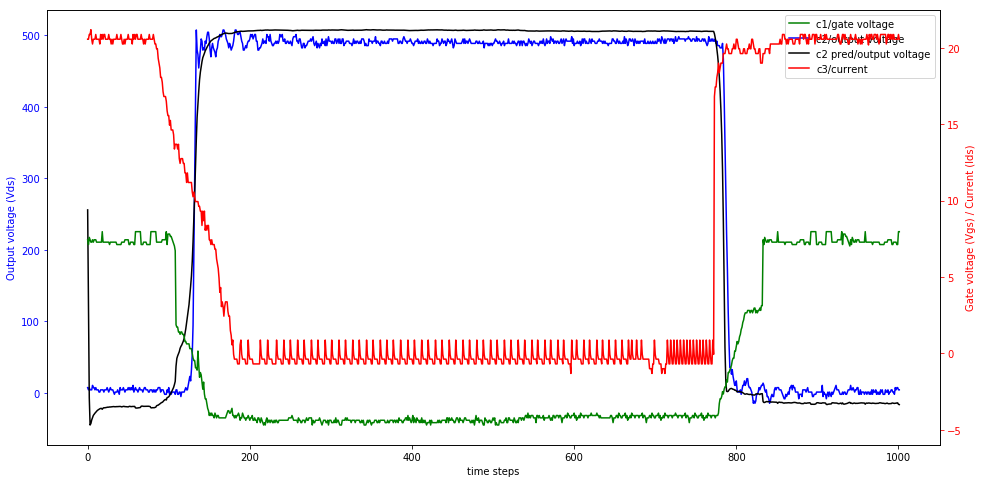

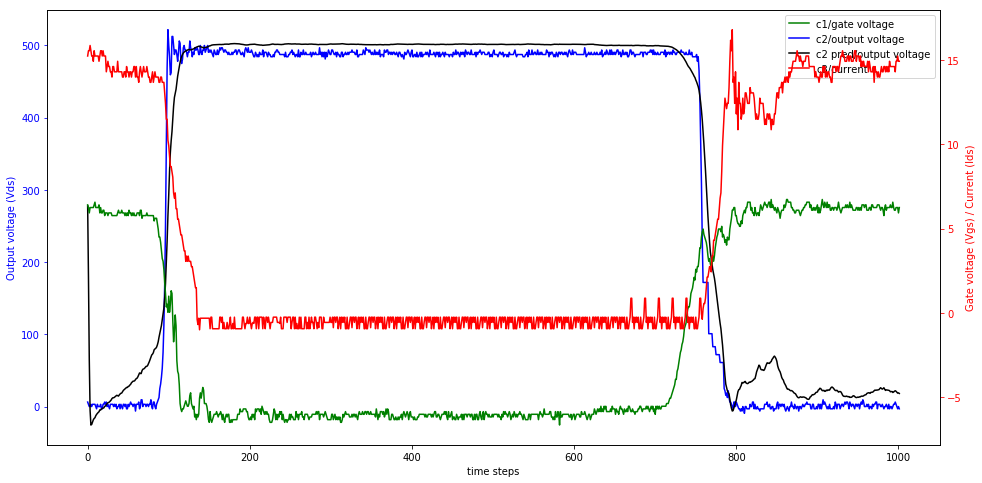

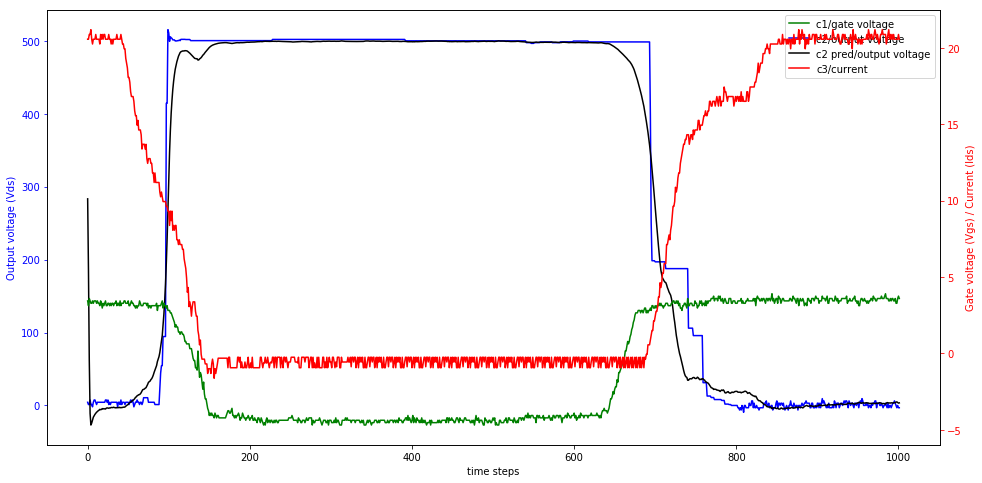

In [48]:
for i in range(x_test.shape[0]):
    plot_prediction(x_test[i], y_test[i], y_test_pred[i])